In [1]:
matplotlib inline

In [2]:
"""
Plot welfare, employment, unemployment, and tax revenue as a function of the
unemployment compensation rate in the lake model.

For fixed parameters 

    alpha = job separation rate, 
    beta = discount rate, 
    gamma = job destruction rate
    w_vec, p_vec = possible wage values and their probabilities
    b, d = entry and exit rates for labor force

and a given utility function u,

"""

import numpy as np 
import matplotlib.pyplot as plt
from lake_model import LakeModel
from scipy.stats import norm
from scipy.optimize import brentq
from numba import jit

# What to do about these imports?  I'm currently using sym links...
from mccall_bellman_iteration import McCallModel  
from compute_reservation_wage import compute_reservation_wage 

# Some global variables that will stay constant

alpha  = 0.013               # monthly
alpha_q = (1-(1-alpha)**3)   # quarterly
b      = 0.0124
d      = 0.00822
beta   = 0.99                   
gamma  = 1.0
sigma  = 2.0
    
# The default wage distribution --- a discretized lognormal

log_wage_mean, wage_grid_size, max_wage = 20, 50, 175
logw_dist = norm(np.log(log_wage_mean), 1)
w_vec = np.linspace(0, max_wage, wage_grid_size + 1) # wage grid
cdf = logw_dist.cdf(np.log(w_vec))
pdf = cdf[1:]-cdf[:-1]
p_vec = pdf / pdf.sum()
w_vec = (w_vec[1:] + w_vec[:-1])/2

# Levels of unemployment insurance we wish to study
c_vec = np.linspace(50, 170, 10)

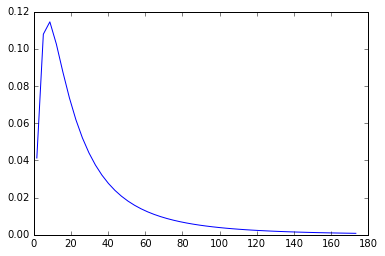

In [3]:
fig, ax = plt.subplots()
ax.plot(w_vec, p_vec)
plt.show()

In [4]:
def compute_optimal_quantities(c, T):
    """
    Compute the reservation wage, job finding rate and value functions of the workers 
    given c and T.

    """
    
    mcm = McCallModel(alpha=alpha_q, 
                     beta=beta, 
                     gamma=gamma, 
                     c=c-T,         # post tax compensation
                     sigma=sigma, 
                     w_vec=w_vec-T, # post tax wages
                     p_vec=p_vec)

    w_bar, V, U = compute_reservation_wage(mcm, return_values=True)
    lmda = gamma* np.sum(p_vec[w_vec > w_bar])
    return w_bar, lmda, V, U

1144
foo
1144
foo
1144
foo
1144
foo
1144
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo


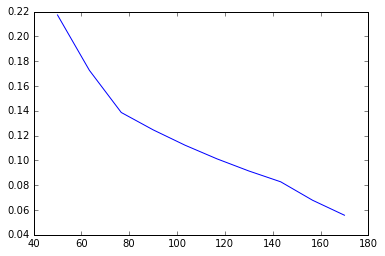

In [5]:
fig, ax = plt.subplots()
lmda_vec = []

for c in c_vec:
    T = 0.5 * c
    w_bar, lmda, V, U = compute_optimal_quantities(c, T)
    lmda_vec.append(lmda)
ax.plot(c_vec, lmda_vec)

In [6]:
lmda_vec

[0.21729125457197782,
 0.17266026273410134,
 0.1386400952059178,
 0.12463799444325152,
 0.11225662178192794,
 0.10126823169958872,
 0.091482520906454631,
 0.082739637985739009,
 0.067863061366377278,
 0.055784145603238501]

In [7]:
def compute_steady_state_quantities(c, T):
    """
    Compute the steady state unemployment rate given c and T using optimal
    quantities from the McCall model and computing corresponding steady state
    quantities

    """
    w_bar, lmda, V, U = compute_optimal_quantities(c, T)
    
    # Compute steady state employment and unemployment rates
    lm = LakeModel(alpha=alpha, lmda=lmda, b=0, d=0) 
    x = lm.rate_steady_state()
    e, u = x
    
    # Compute steady state welfare
    w = np.sum(V * p_vec * (w_vec > w_bar)) / np.sum(p_vec * (w_vec > w_bar))
    welfare = e * w + u * U
    
    return e, u, welfare

In [8]:
def find_balanced_budget_tax(c):
    """
    Find the smallest tax that will induce a balanced budget

    """
    def steady_state_budget(t):
        e, u, w = compute_steady_state_quantities(c, t)
        return t - u * c

    T = brentq(steady_state_budget, 0.0, 0.9 * c)
    return T

In [9]:
## Now step through all c values to be considered.  At each one, find budget
## balancing T, and then evaluate welfare, employment and unemployment at this
## pair (c, T).  Plot the values against c.

In [10]:
tax_vec = []
unempl_vec = []
empl_vec = []
welfare_vec = []

for c in c_vec:
    t = find_balanced_budget_tax(c)
    e_rate, u_rate, welfare = compute_steady_state_quantities(c, t)
    tax_vec.append(t)
    unempl_vec.append(u_rate)
    empl_vec.append(e_rate)
    welfare_vec.append(welfare)

1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1139
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1145
foo
1

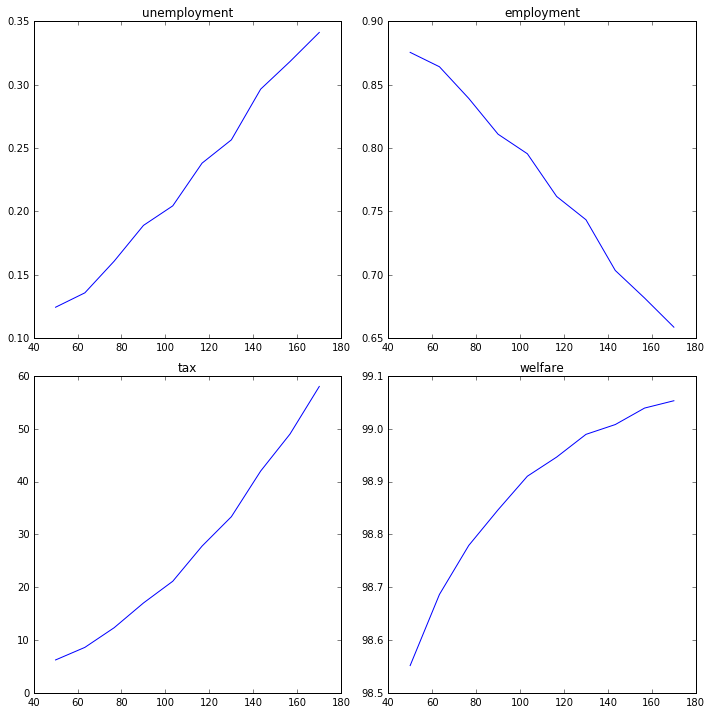

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

ax = axes[0, 0]
ax.plot(c_vec, unempl_vec)
ax.set_title('unemployment')

ax = axes[0, 1]
ax.plot(c_vec, empl_vec)
ax.set_title('employment')

ax = axes[1, 0]
ax.plot(c_vec, tax_vec)
ax.set_title('tax')

ax = axes[1, 1]
ax.plot(c_vec, welfare_vec)
ax.set_title('welfare')

plt.tight_layout()
plt.show()

In [12]:
welfare_vec

[97.911680302885259,
 98.045482690684906,
 98.137601584239121,
 98.204600428413784,
 98.267766888124953,
 98.303776801362602,
 98.346462553151241,
 98.364875798152624,
 98.39582738129775,
 98.409523933957331]